<a href="https://www.kaggle.com/code/deepkayastha6890/bank-loan-risk-pattern-finder?scriptVersionId=296007387" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [19]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

# Addition paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-transaction-data/bank.xlsx


### Finding the file and assigning the dataframe column

In [20]:
file_path = 'bank.xlsx'

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "apoorvwatsky/bank-transaction-data",
    file_path,
)

# Dataframe first five rows
print("\n\nFirst 5 records:")
display(df.head())


/tmp/ipykernel_55/3806805928.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(




First 5 records:


,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


### In this cell cleaning the null data also removing the no needed columns

In [31]:
def DataCleaning(df): 
    
    cleaningData = df.copy()

    #Finding the information 
    print("\n\nInformations:\n",cleaningData.info())

    # Finding the null values
    majorColumns = ['DEPOSIT AMT','WITHDRAWAL AMT','DATE','VALUE DATE']
    for i in majorColumns:
        print(f'\n\n{i} : ',cleaningData[i].isnull().sum())

    # Filling the null values
    nullValuesFiller = ['DEPOSIT AMT','WITHDRAWAL AMT','CHQ.NO.']
    for i in nullValuesFiller:
        cleaningData[i] = cleaningData[i].fillna(0)

    # Just changing the date name
    cleaningData['ActualDate'] = cleaningData['VALUE DATE']
    
    # Seperating the day , month , year 
    cleaningData['ActualDay'] = cleaningData['VALUE DATE'].dt.day 
    cleaningData['ActualMonth'] = cleaningData['VALUE DATE'].dt.month
    cleaningData['ActualYear'] = cleaningData['VALUE DATE'].dt.year

    # Sorting the data from starting date
    cleaningData = cleaningData.sort_values(by="VALUE DATE", ascending=False)

    # Droping unuseful data colums [Account No, , . ,CHQ.NO. ]
    cleaningData = cleaningData.drop(columns=['.','CHQ.NO.','VALUE DATE'])
    
    return cleaningData
    
cleanData = DataCleaning(df)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Account No           116201 non-null  object        
 1   DATE                 116201 non-null  datetime64[ns]
 2   TRANSACTION DETAILS  113702 non-null  object        
 3   CHQ.NO.              905 non-null     float64       
 4   VALUE DATE           116201 non-null  datetime64[ns]
 5   WITHDRAWAL AMT       53549 non-null   float64       
 6   DEPOSIT AMT          62652 non-null   float64       
 7   BALANCE AMT          116201 non-null  float64       
 8   .                    116201 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 8.0+ MB


Informations:
 None


DEPOSIT AMT :  53549


WITHDRAWAL AMT :  62652


DATE :  0


VALUE DATE :  0


In [33]:
def DataDiscribtion(df):

    dataDiscribe = df.copy()
    # Finding the columns 
    print('\n')
    print(dataDiscribe.columns)

    # finding the shape
    print("\nDataset Size",dataDiscribe.shape)

    # Finding the data discribtion 
    print('\nDiscribtion of the data : ')
    display(dataDiscribe.describe())

    
    # Year wise count
    total_year_counts = dataDiscribe['ActualYear'].value_counts()

    print("Total list of year : ")
    display(total_year_counts.head())
    print("\n")
    
    # Less Then Zero balance
    count =0
    for value in dataDiscribe['BALANCE AMT']:
        if(value < 0):
            count = count +1;
    
    # Counting the minus value
    print("\n\nMinus Value in balance : ",count)
    
    # Finding the data distribution
    print('\n\nUnique value of the account numbers')
    display(dataDiscribe['Account No'].unique())
    
DataDiscribtion(cleanData)




Index(['Account No', 'DATE', 'TRANSACTION DETAILS', 'WITHDRAWAL AMT',
       'DEPOSIT AMT', 'BALANCE AMT', 'ActualDate', 'ActualDay', 'ActualMonth',
       'ActualYear'],
      dtype='object')

Dataset Size (116201, 10)

Discribtion of the data : 


,DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDate,ActualDay,ActualMonth,ActualYear
count,116201,1.162010e+05,1.162010e+05,1.162010e+05,116201,116201.000000,116201.000000,116201.000000
mean,2017-05-20 00:08:40.477448448,2.068757e+06,2.052394e+06,-1.404852e+09,2017-05-20 00:04:43.288440064,15.615907,6.680313,2016.869993
min,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,-2.045201e+09,2015-01-01 00:00:00,1.000000,1.000000,2015.000000
25%,2016-05-30 00:00:00,0.000000e+00,0.000000e+00,-1.690383e+09,2016-05-30 00:00:00,8.000000,4.000000,2016.000000
50%,2017-06-05 00:00:00,0.000000e+00,5.000000e+03,-1.661395e+09,2017-06-05 00:00:00,15.000000,7.000000,2017.000000
75%,2018-05-26 00:00:00,2.682500e+04,5.000000e+05,-1.236888e+09,2018-05-26 00:00:00,23.000000,10.000000,2018.000000
max,2019-03-05 00:00:00,4.594475e+08,5.448000e+08,8.500000e+06,2019-03-05 00:00:00,31.000000,12.000000,2019.000000
std,NaN,7.696881e+06,6.652164e+06,5.348202e+08,NaN,8.602524,3.491998,1.131124


Total list of year : 


ActualYear
2018    35534
2016    30373
2017    29112
2015    15658
2019     5524
Name: count, dtype: int64





Minus Value in balance :  113276


Unique value of the account numbers


array(["409000362497'", "409000438620'", "1196428'", "409000438611'",
       "409000493210'", "409000493201'", "409000405747'", "409000425051'",
       "1196711'", "409000611074'"], dtype=object)

### Actual Dataset have total 10 use full column 
- In the dataset there is multiple account numbers
- Total rows 116201
- total 5 years of data is availble

### Using this two function we can group the dataset

In [23]:
# Count of compressed features
def groupByCounting(df, respectedMainFeature, copresstionFeatures):
    return (
        df
        .groupby(respectedMainFeature)[copresstionFeatures]
        .count()
        .sort_index()
    )
# Sum of the compress features
def groupBySum(df, respectedMainFeature, copresstionFeatures):
    return (
        df
        .groupby(respectedMainFeature)[copresstionFeatures]
        .sum()
        .sort_index()
    )


# This is the main feature engineering portion using this we have the risk factors and risk of the bank account

In [24]:
# Day wise data process and account No wise classifier
def build_daily_account_log(df):

    # Day wise agrigated data and this data is days wise
    daily_log = (
        df
        .sort_values(['Account No', 'DATE'])
        .groupby(['Account No', 'DATE'])
        .agg(
            TotalDeposit=('DEPOSIT AMT', 'sum'),
            TotalWithdrawal=('WITHDRAWAL AMT', 'sum'),
            EndBalance=('BALANCE AMT', 'last'),
            TxnCount=('BALANCE AMT', 'count')
        )
        .reset_index()
    )

    # Net movement for the day
    daily_log['NetChange'] = (
        daily_log['TotalDeposit'] - daily_log['TotalWithdrawal']
    )

    # This making diffrent dataframes 
    daily_account_df = daily_log


    # Now daily_account_df is new all in one data frame
    # If overdraf this goes true
    daily_account_df['IsOverdraft'] = daily_account_df['EndBalance'] < 0
    
    # Marking overdraft
    daily_account_df['OverdraftAmount'] = (
        -daily_account_df['EndBalance']
    ).clip(lower=0)

    # Daily balance change
    daily_account_df['DailyBalanceChange'] = (
    daily_account_df
        .groupby('Account No')['EndBalance']
        .diff()
    )
    daily_account_df['MONTH'] = daily_account_df['DATE'].dt.to_period('M')

    # Two dataframes are there
    return daily_log , daily_account_df
_ , manngedData = build_daily_account_log(cleanData)

display(manngedData.shape)
display(manngedData.head())


(6218, 11)

,Account No,DATE,TotalDeposit,TotalWithdrawal,EndBalance,TxnCount,NetChange,IsOverdraft,OverdraftAmount,DailyBalanceChange,MONTH
0,1196428',2015-01-01,2000000.0,0.00,-1.584916e+09,2,2000000.00,True,1.584916e+09,NaN,2015-01
1,1196428',2015-01-02,2462620.0,5500056.18,-1.587953e+09,9,-3037436.18,True,1.587953e+09,-3037436.18,2015-01
2,1196428',2015-01-03,2948160.0,2200000.00,-1.587205e+09,4,748160.00,True,1.587205e+09,748160.00,2015-01
3,1196428',2015-01-05,3877320.0,3231000.00,-1.586736e+09,5,646320.00,True,1.586736e+09,469000.00,2015-01
4,1196428',2015-01-06,3650750.0,3880056.18,-1.587131e+09,6,-229306.18,True,1.587131e+09,-395236.18,2015-01


In [25]:
def monthly_account_features(df):

    df = df.sort_values(['Account No', 'DATE']).copy()

    # putting the feature risk one row behind
    df['StreakStart'] = (
        (df['IsOverdraft']) &
        (~df.groupby('Account No')['IsOverdraft'].shift(fill_value=False))
    )

    # Assigning the streak id
    df['StreakID'] = df.groupby('Account No')['StreakStart'].cumsum()

    # Counting the overdraft day
    overdraft_days = df[df['IsOverdraft']]

    
    streaks = (
        overdraft_days
        .groupby(['Account No', 'MONTH', 'StreakID'])
        .size()
        .reset_index(name='StreakLength')
    )

    # Avg overdraft streak per month (Recovery Velocity)
    recovery_velocity = (
        streaks
        .groupby(['Account No', 'MONTH'])['StreakLength']
        .mean()
        .reset_index(name='RecoveryVelocity')
    )

    # MONTHLY grouping the data 
    monthly = (
        df
        .groupby(['Account No', 'MONTH'])
        .agg(
            DaysInMonth=('DATE', 'nunique'),
            StressDays=('IsOverdraft', 'sum'),
            NetCashflow=('NetChange', 'sum'),
            TotalTxn=('TxnCount', 'sum'),
            MaxWithdrawal=('TotalWithdrawal', 'max'),
            AvgEndBalance=('EndBalance', 'mean'),
            BalanceVolatility=('EndBalance', 'std')
        )
        .reset_index()
    )

    # 2. Whale Impact
    monthly['WhaleImpact'] = (
        monthly['MaxWithdrawal'] /
        monthly['AvgEndBalance'].abs()
    )

    # 3. Stress Duration
    monthly['StressDuration'] = (
        monthly['StressDays'] / monthly['DaysInMonth']
    )

    # 5. Operational Intensity
    monthly['OperationalIntensity'] = (
        monthly['TotalTxn'] / monthly['DaysInMonth']
    )

    # MERGE RECOVERY VELOCITY
    final_features = monthly.merge(
        recovery_velocity,
        on=['Account No', 'MONTH'],
        how='left'
    )

    # If no overdraft streaks → velocity = 0
    final_features['RecoveryVelocity'] = (
        final_features['RecoveryVelocity'].fillna(0)
    )

    return final_features
monthly_features = monthly_account_features(manngedData)
monthly_features.head()


,Account No,MONTH,DaysInMonth,StressDays,NetCashflow,TotalTxn,MaxWithdrawal,AvgEndBalance,BalanceVolatility,WhaleImpact,StressDuration,OperationalIntensity,RecoveryVelocity
0,1196428',2015-01,26,26,2409931.64,191,9230000.0,-1.586814e+09,2.355750e+06,0.005817,1.0,7.346154,26.0
1,1196428',2015-02,24,24,1455434.00,262,9350500.0,-1.586019e+09,2.706476e+06,0.005896,1.0,10.916667,24.0
2,1196428',2015-03,25,25,-4449586.00,237,9750000.0,-1.586510e+09,2.486767e+06,0.006146,1.0,9.480000,25.0
3,1196428',2015-04,24,24,489124.00,256,10000000.0,-1.587227e+09,2.138390e+06,0.006300,1.0,10.666667,24.0
4,1196428',2015-05,26,26,590534.00,378,14500000.0,-1.586181e+09,2.770573e+06,0.009141,1.0,14.538462,26.0


In [26]:
# creating new feature
def modelDataFrame(df):

    df['Norm_Recovery'] = (df['RecoveryVelocity'] / 30.0).clip(upper=1.0)

    df['Norm_Stress'] = df['StressDuration'].clip(upper=1.0)

    # Net Cashflow (High Impact):
    df['Norm_Cashflow'] = np.where(
        df['NetCashflow'] >= 0, 
        0.0, 
        (df['NetCashflow'].abs() / df['AvgEndBalance'].abs()).clip(upper=1.0)
    )

    # Whale Impact (Medium)
    df['Norm_Whale'] = df['WhaleImpact'].clip(upper=1.0)

    # Operational Intensity (Low)
    df['Norm_Intensity'] = (df['OperationalIntensity'] / 50.0).clip(upper=1.0)

    # Balance Volatility (Low)
    df['Norm_Volatility'] = (df['BalanceVolatility'] / df['AvgEndBalance'].abs()).clip(upper=1.0)


    # Weights according to priority

    weights = {
        'Recovery': 0.30,   
        'Stress': 0.25,     
        'Cashflow': 0.20,   
        'Whale': 0.15,      
        'Intensity': 0.05,   
        'Volatility': 0.05  
    }

    # Calculate the Weighted Sum
    df['Risk_Score'] = (
        (df['Norm_Recovery'] * weights['Recovery']) +
        (df['Norm_Stress'] * weights['Stress']) +
        (df['Norm_Cashflow'] * weights['Cashflow']) +
        (df['Norm_Whale'] * weights['Whale']) +
        (df['Norm_Intensity'] * weights['Intensity']) +
        (df['Norm_Volatility'] * weights['Volatility'])
    ) * 100

    # Round for cleaner display
    df['Risk_Score'] = df['Risk_Score'].round(2)
    return df
    
modelData = modelDataFrame(monthly_features)


modelData = modelData.sort_values(['Account No', 'MONTH'])
modelData['FutureRisk'] = modelData.groupby('Account No')['Risk_Score'].shift(-1)

train_df = modelData.dropna(subset=['FutureRisk'])
live_df  = modelData[modelData['FutureRisk'].isna()]
train_df

,Account No,MONTH,DaysInMonth,StressDays,NetCashflow,TotalTxn,MaxWithdrawal,AvgEndBalance,BalanceVolatility,WhaleImpact,...,OperationalIntensity,RecoveryVelocity,Norm_Recovery,Norm_Stress,Norm_Cashflow,Norm_Whale,Norm_Intensity,Norm_Volatility,Risk_Score,FutureRisk
0,1196428',2015-01,26,26,2409931.64,191,9230000.0,-1.586814e+09,2.355750e+06,0.005817,...,7.346154,26.0,0.866667,1.0,0.000000,0.005817,0.146923,0.001485,51.83,50.19
1,1196428',2015-02,24,24,1455434.00,262,9350500.0,-1.586019e+09,2.706476e+06,0.005896,...,10.916667,24.0,0.800000,1.0,0.000000,0.005896,0.218333,0.001706,50.19,51.10
2,1196428',2015-03,25,25,-4449586.00,237,9750000.0,-1.586510e+09,2.486767e+06,0.006146,...,9.480000,25.0,0.833333,1.0,0.002805,0.006146,0.189600,0.001567,51.10,50.17
3,1196428',2015-04,24,24,489124.00,256,10000000.0,-1.587227e+09,2.138390e+06,0.006300,...,10.666667,24.0,0.800000,1.0,0.000000,0.006300,0.213333,0.001347,50.17,52.60
4,1196428',2015-05,26,26,590534.00,378,14500000.0,-1.586181e+09,2.770573e+06,0.009141,...,14.538462,26.0,0.866667,1.0,0.000000,0.009141,0.290769,0.001747,52.60,53.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,409000611074',2018-09,22,0,-611797.00,74,848198.0,1.254017e+06,2.381002e+05,0.676385,...,3.363636,0.0,0.000000,0.0,0.487870,0.676385,0.067273,0.189870,21.19,12.94
324,409000611074',2018-10,23,0,514240.00,89,943915.0,1.232687e+06,2.634024e+05,0.765738,...,3.869565,0.0,0.000000,0.0,0.000000,0.765738,0.077391,0.213682,12.94,14.60
325,409000611074',2018-11,22,0,15234.00,90,1043104.0,1.222012e+06,3.385816e+05,0.853596,...,4.090909,0.0,0.000000,0.0,0.000000,0.853596,0.081818,0.277069,14.60,10.24
326,409000611074',2018-12,23,0,381060.00,85,872358.0,1.416153e+06,1.786344e+05,0.616005,...,3.695652,0.0,0.000000,0.0,0.000000,0.616005,0.073913,0.126141,10.24,21.34


/tmp/ipykernel_55/1227804615.py:3: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(train_df['MONTH']):
/tmp/ipykernel_55/1227804615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Account No'] = train_df['Account No'].astype(str)


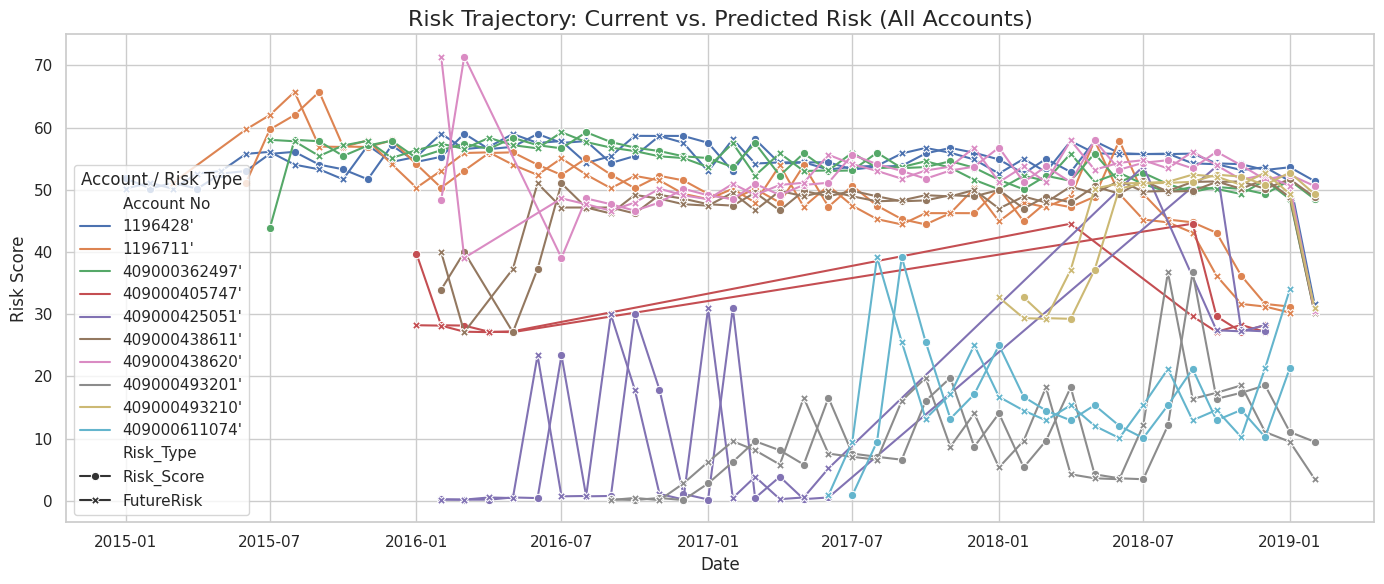

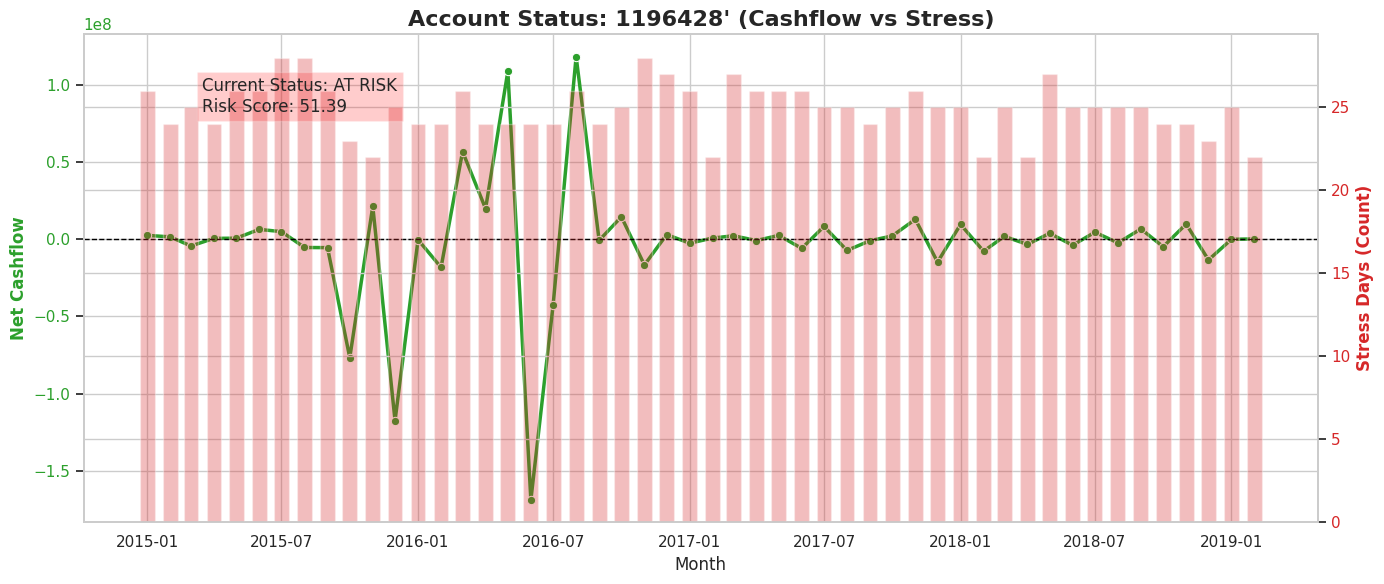

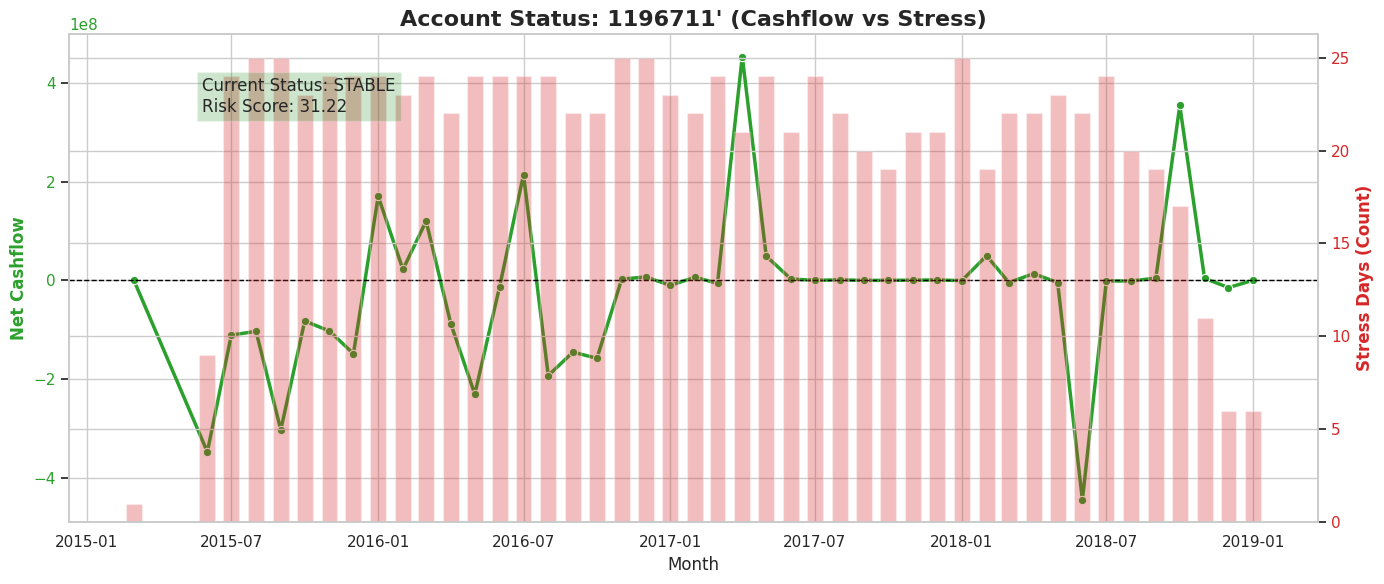

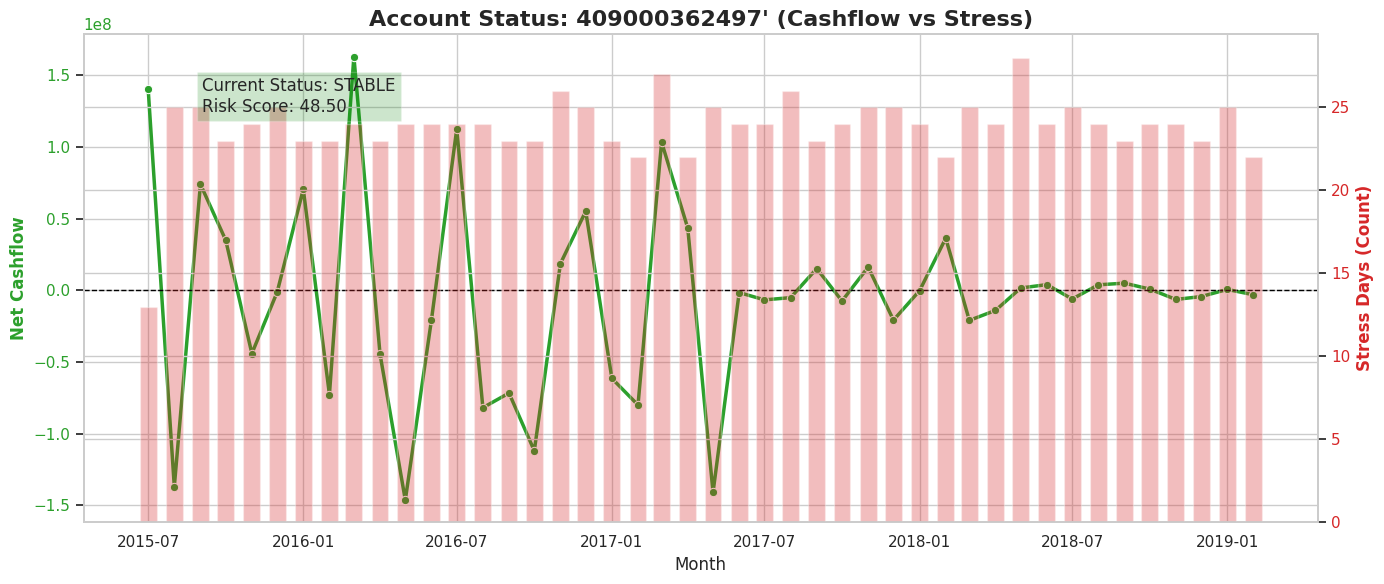

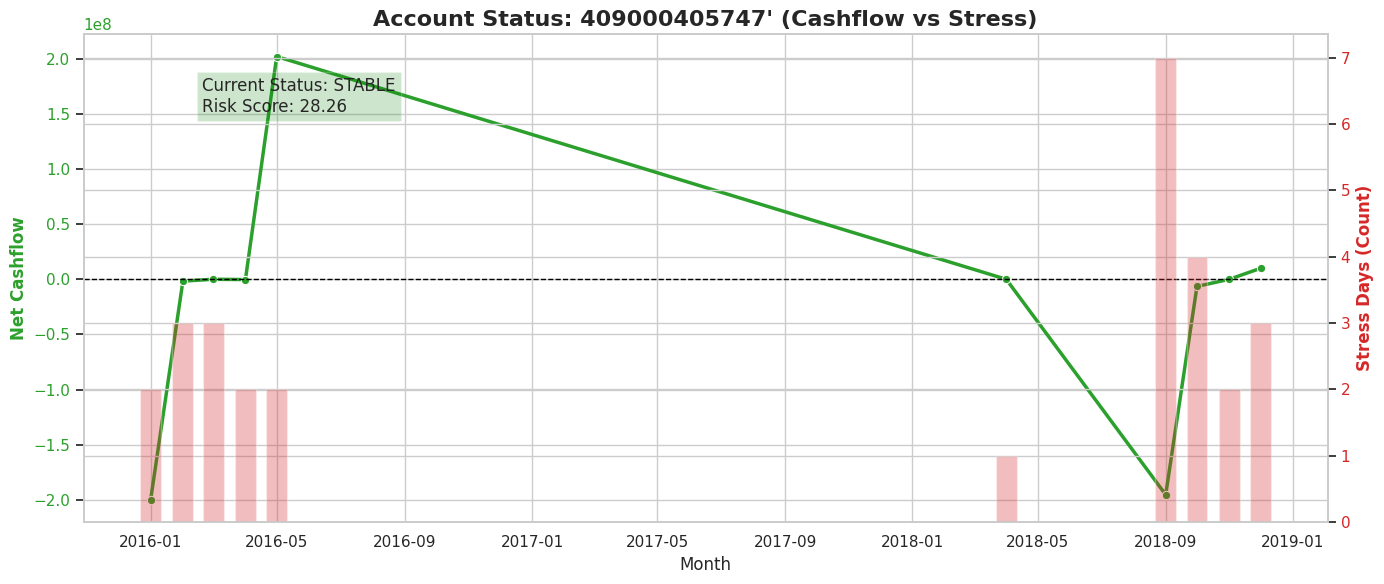

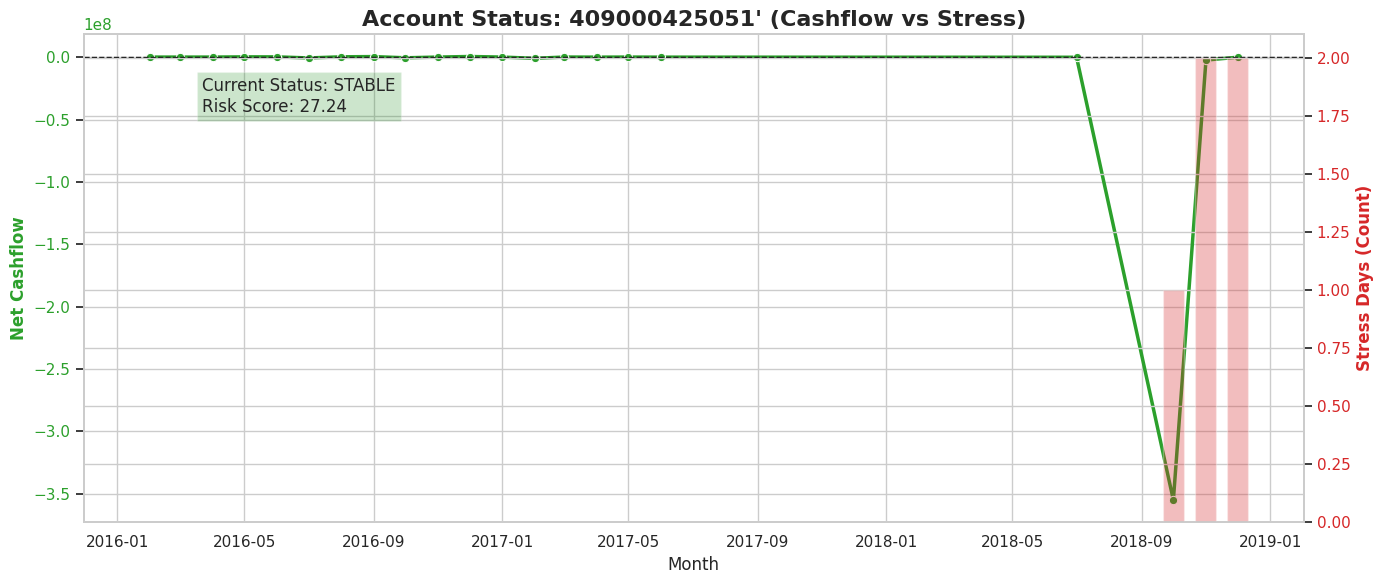

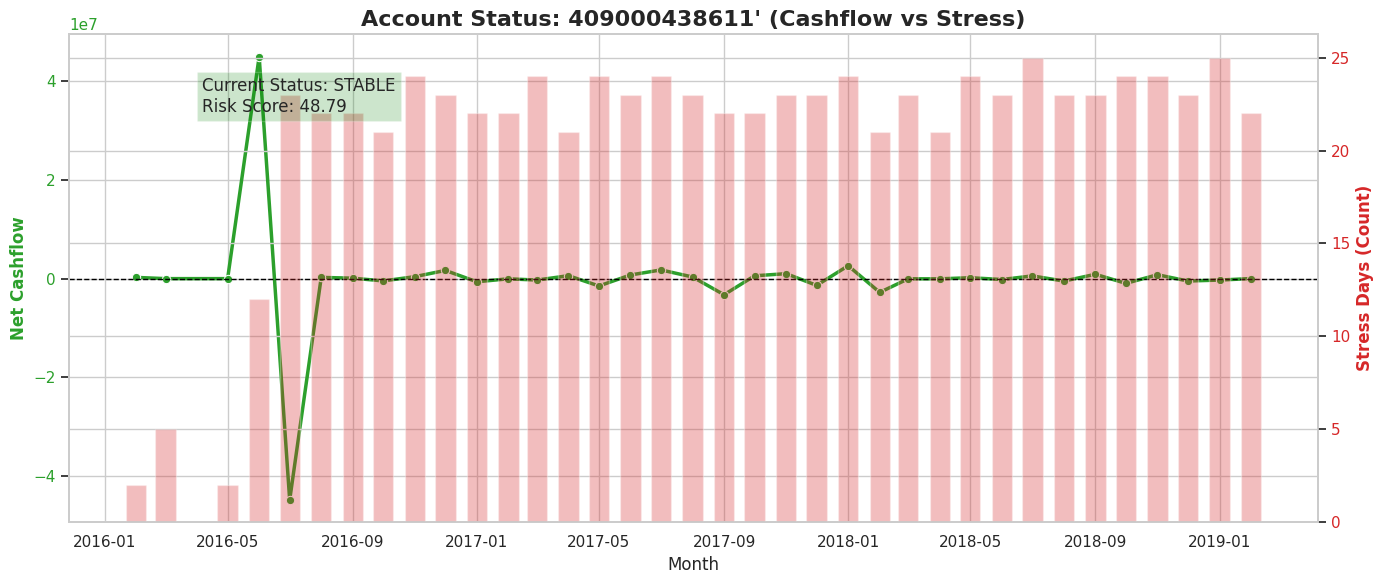

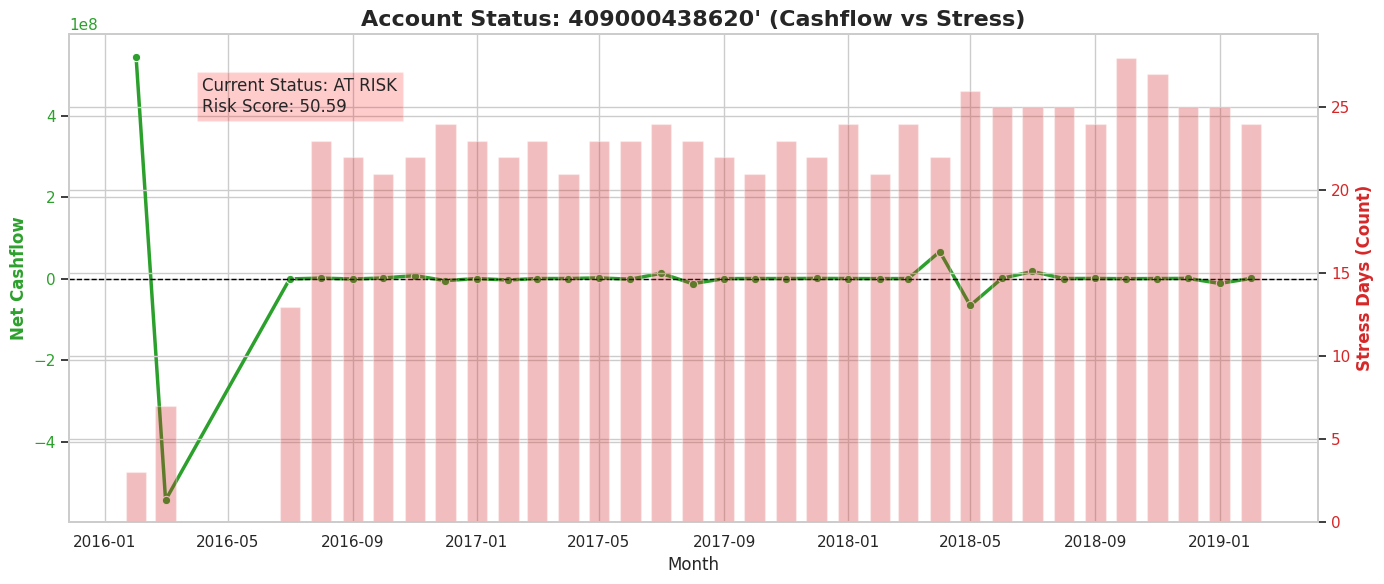

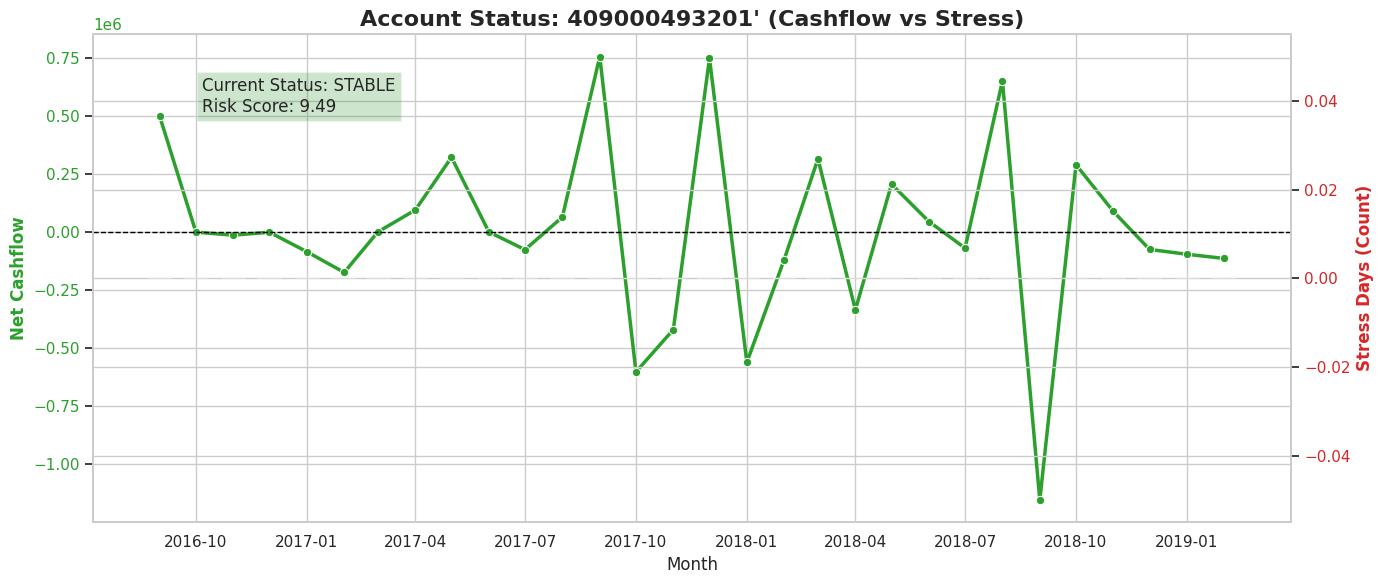

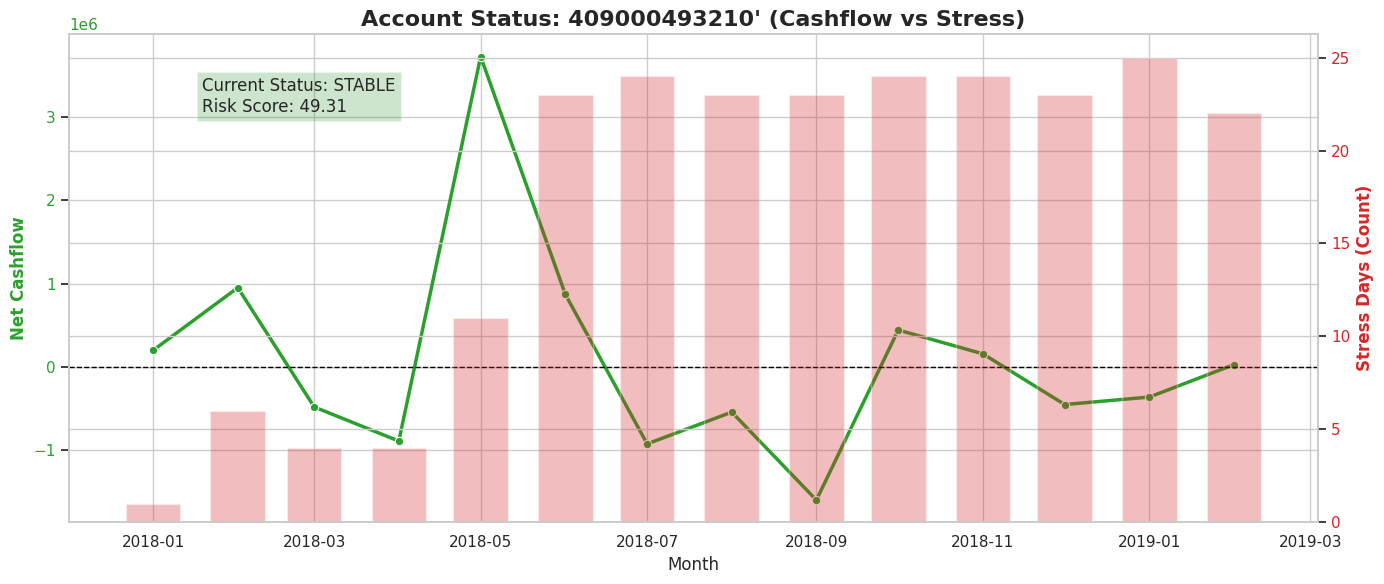

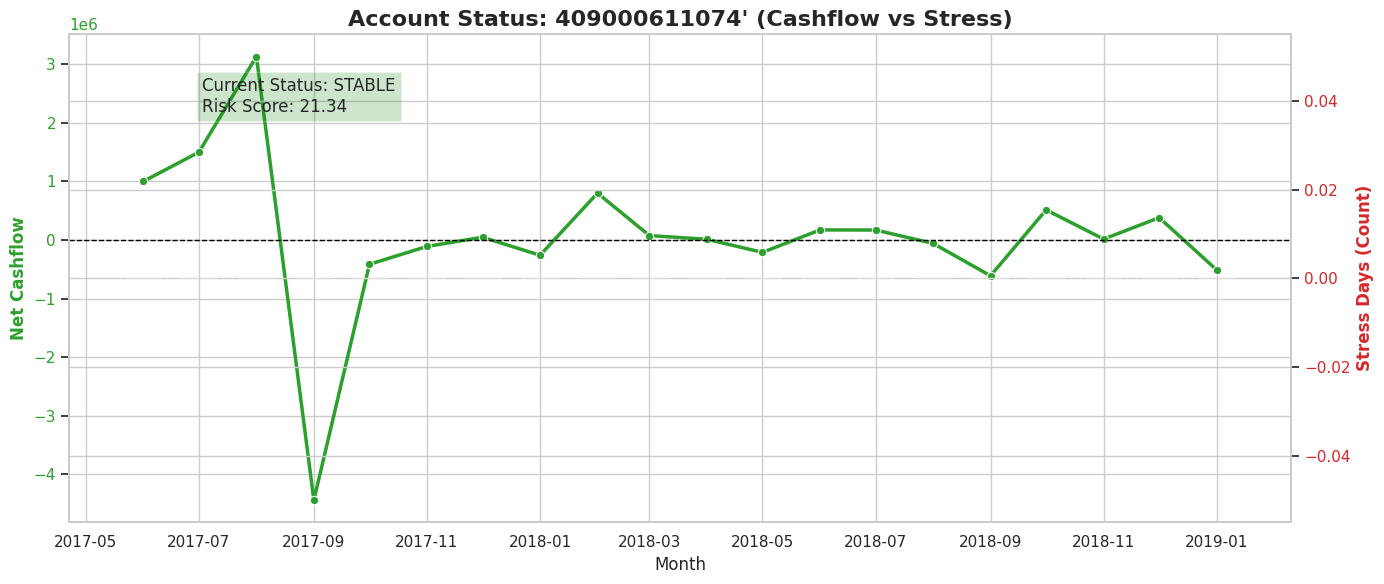

In [29]:
import matplotlib.dates as mdates

if pd.api.types.is_period_dtype(train_df['MONTH']):
    train_df['MONTH'] = train_df['MONTH'].dt.to_timestamp()
else:
    # Only convert if it's not already datetime
    if not pd.api.types.is_datetime64_any_dtype(train_df['MONTH']):
        train_df['MONTH'] = pd.to_datetime(train_df['MONTH'])

train_df['Account No'] = train_df['Account No'].astype(str)

sns.set_theme(style="whitegrid")
accounts = train_df['Account No'].unique()

plt.figure(figsize=(14, 6))
risk_melt = train_df.melt(id_vars=['Account No', 'MONTH'], 
                          value_vars=['Risk_Score', 'FutureRisk'], 
                          var_name='Risk_Type', value_name='Score')

sns.lineplot(data=risk_melt, x='MONTH', y='Score', hue='Account No', style='Risk_Type', markers=True, dashes=False)
plt.title('Risk Trajectory: Current vs. Predicted Risk (All Accounts)', fontsize=16)
plt.ylabel('Risk Score')
plt.xlabel('Date')
plt.legend(title='Account / Risk Type')
plt.tight_layout()
plt.show()

# account wise net cashflow and risk score
for acc in accounts:
    subset = train_df[train_df['Account No'] == acc]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    color_cash = 'tab:green'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Net Cashflow', color=color_cash, fontweight='bold')
    sns.lineplot(data=subset, x='MONTH', y='NetCashflow', ax=ax1, color=color_cash, marker='o', linewidth=2.5)
    ax1.tick_params(axis='y', labelcolor=color_cash)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1) # Zero line
    
    ax2 = ax1.twinx()
    color_stress = 'tab:red'
    ax2.set_ylabel('Stress Days (Count)', color=color_stress, fontweight='bold')
    
    width = 20 
    ax2.bar(subset['MONTH'], subset['StressDays'], color=color_stress, alpha=0.3, width=20, label='Stress Days')
    ax2.tick_params(axis='y', labelcolor=color_stress)
    
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title(f'Account Status: {acc} (Cashflow vs Stress)', fontsize=16, weight='bold')
    
    latest = subset.iloc[-1]
    status_text = "STABLE" if latest['Risk_Score'] < 50 else "AT RISK"
    status_color = "green" if status_text == "STABLE" else "red"
    
    plt.figtext(0.15, 0.8, f"Current Status: {status_text}\nRisk Score: {latest['Risk_Score']:.2f}", 
                bbox=dict(facecolor=status_color, alpha=0.2), fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def train_and_predict_future_risk(train_df, live_df):
    feature_cols = [
        'Norm_Recovery',
        'Norm_Stress',
        'Norm_Cashflow',
        'Norm_Whale',
        'Norm_Intensity',
        'Norm_Volatility'
    ]
    # Precheck
    for col in feature_cols + ['FutureRisk']:
        if col not in train_df.columns:
            raise ValueError(f"Missing column: {col}")

    # sorting the training set
    train_df = train_df.sort_values(['Account No', 'MONTH'])

    # spliting 80% set
    split_point = train_df['MONTH'].quantile(0.8)
    train_part = train_df[train_df['MONTH'] <= split_point]
    val_part   = train_df[train_df['MONTH'] > split_point]

    # final training set
    X_train = train_part[feature_cols]
    y_train = train_part['FutureRisk']

    X_val = val_part[feature_cols]
    y_val = val_part['FutureRisk']

    # Xg Boost
    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )

    model.fit(X_train, y_train)

    # Validate the Model 
    val_preds = model.predict(X_val)

    metrics = {
        'MAE': mean_absolute_error(y_val, val_preds),
        'RMSE': np.sqrt(mean_squared_error(y_val, val_preds)),
        'R2': r2_score(y_val, val_preds)
    }

    # Pridicting value live
    live_df = (
        live_df
        .sort_values(['Account No', 'MONTH'])
        .groupby('Account No')
        .tail(1)
        .copy()
    )

    live_df['PredictedFutureRisk'] = model.predict(
        live_df[feature_cols]
    )

    live_predictions = live_df[
        ['Account No', 'MONTH', 'PredictedFutureRisk']
    ].reset_index(drop=True)

    # Predict on validation set
    val_preds = model.predict(X_val)

    # Visulizing the outcomes
    plt.figure(figsize=(6,6))
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             linestyle='--')

    plt.xlabel("Actual Future Risk")
    plt.ylabel("Predicted Future Risk")
    plt.title("Predicted vs Actual Future Risk (Validation)")
    plt.show()

    residuals = y_val - val_preds

    plt.figure(figsize=(6,4))
    plt.scatter(val_preds, residuals, alpha=0.5)
    plt.axhline(0, linestyle='--')

    plt.xlabel("Predicted Future Risk")
    plt.ylabel("Residual (Actual − Predicted)")
    plt.title("Residuals vs Predicted Risk")
    plt.show()

    # Importance matrix
    importance = pd.Series(
        model.feature_importances_,
        index=X_train.columns
    ).sort_values()

    plt.figure(figsize=(6,4))
    importance.plot(kind='barh')
    plt.xlabel("Importance")
    plt.title("Feature Importance – Future Risk Model")
    plt.show()


    return model, metrics, live_predictions
_,metrics,pridictions = train_and_predict_future_risk(train_df, live_df)

print(metrics)